# Notebook examples for Chapter 3

## 3.1 The discrete Fourier transform

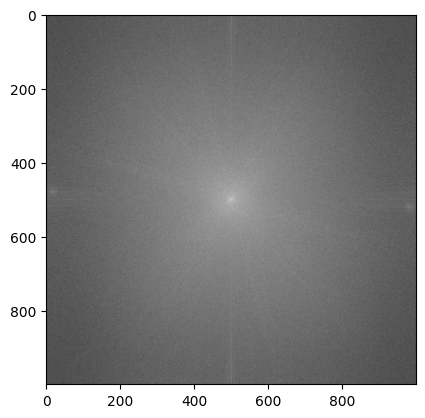

In [1]:
import numpy as np
from numpy import fft
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
import matplotlib.pyplot as plt

gdal.AllRegister()
infile = 'imagery/AST_20070501.tif'
                  
inDataset = gdal.Open(infile,GA_ReadOnly)     
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    

band = inDataset.GetRasterBand(3)  
image = band.ReadAsArray(0,0,cols,rows)
#  arrays of i and j values    
a = np.reshape(range(rows*cols),(rows,cols))
i = a % cols
j = a // cols
#  shift Fourier transform to center    
image1 = (-1)**(i+j)*image
#  compute power spectrum and display    
image1 = np.log(np.abs(fft.fft2(image1))**2)
mn = np.amin(image1)
mx = np.amax(image1)
plt.imshow((image1-mn)/(mx-mn), cmap='gray')   

#plt.savefig('/home/mort/LaTeX/new projects/CRC5/Chapter3/fig3_1.eps')

## 3.2 The discrete wavelet transform

### 3.2.2 Image compression

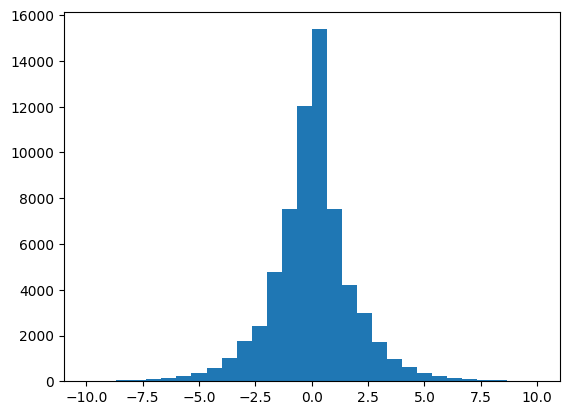

In [2]:
# The Haar mother wavelet
def psi_m(x):
    if x<0:return 0.0 
    elif x<=0.5:return 1.0
    elif x<=1.0:return -1.0
    else:return 0.0
# The Haar basis functions   
def psi(m,k,n):
    c = 2**n
    result = np.zeros(c)
    x = np.linspace(0,1,num=c)
    for i in range(c):
        result[i] = psi_m((2**m)*x[i]-k)
    return result

# Generate wavelet basis B_8
n = 8
B = np.ones((2**n,2**n))
i = 1
for m in range(n):
    for k in range(2**m):
        B[:,i] = psi(m,k,n)
        i += 1
B = np.mat(B)  

# 256x256 subset
G = np.mat(image[200:456,200:456])

# Wavelet transformation
Gw = np.mat(np.zeros((256,256)))
# Filter the columns
for j in range(256):
    Gw[:,j] = B.I*G[:,j]
# Filter the rows    
for i in range(256):
    Gw[i,:] = (B.I*Gw[i,:].T).T
# Histogram of wavelet coefficients    
Gw = np.array(Gw).ravel()
p = plt.hist(Gw,bins=30,range=(-10,10))

#plt.savefig('/home/mort/LaTeX/new projects/CRC5/Chapter3/fig3_6.eps')

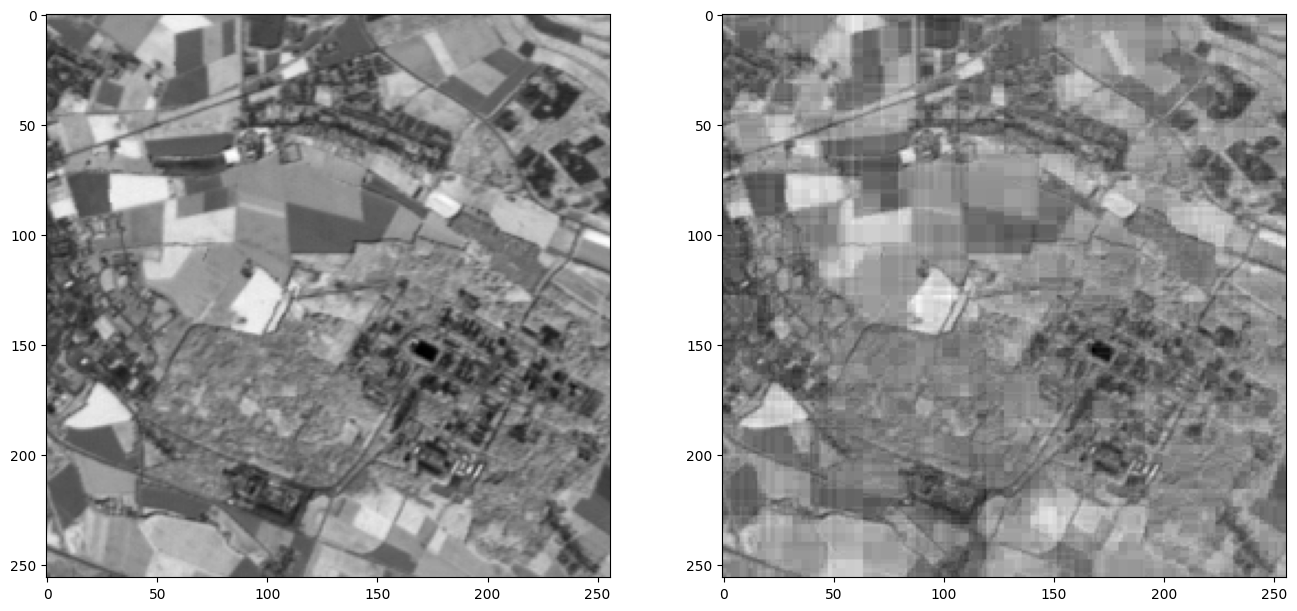

In [3]:
# Truncate and reshape
Gw = np.reshape(np.where(np.abs(Gw)<2,0,Gw),(256,256))
# Invert the transformation
Gw = np.mat(Gw)
Gc = np.mat(np.zeros((256,256)))
for i in range(256):
    Gc[i,:] = (B*Gw[i,:].T).T
for j in range(256):    
    Gc[:,j] = B*Gc[:,j]
f, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(np.array(G)/255,cmap='gray')
ax[1].imshow(np.array(Gc)/255,cmap='gray')

#f.savefig('/home/mort/LaTeX/new projects/CRC5/Chapter3/fig3_7.eps',bbox_inches='tight')

In [4]:
from scipy import sparse

sG = sparse.csr_matrix(G)
sGw = sparse.csr_matrix(Gw)
print(sG.data.nbytes)
print(sGw.data.nbytes)

262144
117088


### 3.2.3 Multiresolution analysis

#### 3.2.3.2 The cascade algorithm

(-1.0, 2.0)

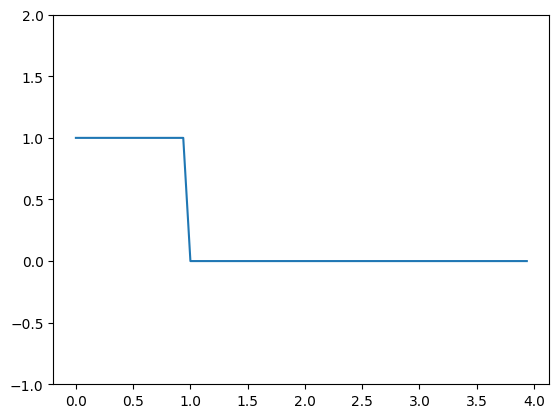

In [5]:
def F(x,i,c):
    if i==0:
        if x==0:
            return 1.0
        else:
            return 0.0
    else:
        return c[0]*F(2*x,i-1,c)+c[1]*F(2*x-1,i-1,c) \
              +c[2]*F(2*x-2,i-1,c)+c[3]*F(2*x-3,i-1,c) \
              +c[4]*F(2*x-4,i-1,c)
            
# Haar refinement coefficients
c = np.zeros(5)
c[0] = 1.0; c[1] = 1.0

# fourth order approximation
n = 4
x = np.array(range(4*2**n))/float(2**n)
FF = np.zeros(4*2**n)
for i in range(4*2**n):
    FF[i] = F(x[i],n,c)
    
plt.plot(x,FF)    
plt.ylim(-1,2)

#plt.savefig('/home/mort/LaTeX/new projects/CRC5/Chapter3/fig3_8.eps')

#### 3.2.3.4 The Daubechies D4 scaling function

(-1.0, 2.0)

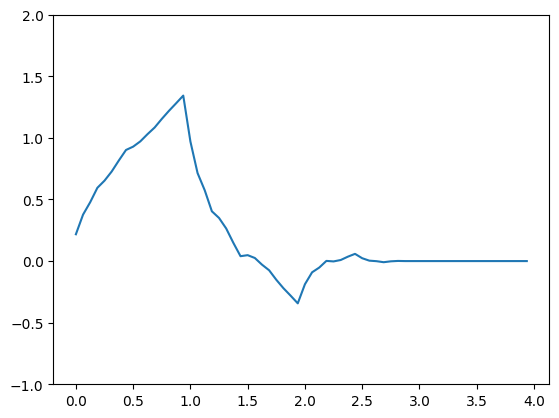

In [6]:
# Daubechies D4 refinement coeffificents
c = np.zeros(5)
c[0] = (1+np.sqrt(3))/4; c[1] = (3+np.sqrt(3))/4
c[2] = (3-np.sqrt(3))/4; c[3] = (1-np.sqrt(3))/4
c[4] = 0.0

for i in range(4*2**n):
    FF[i] = F(x[i],n,c)
    
plt.plot(x,FF)    
plt.ylim(-1,2)

#plt.savefig('/home/mort/LaTeX/new projects/CRC5/Chapter3/fig3_9.eps')

## 3.3 Principal components

### 3.3.1 Principal components on the GEE

In [8]:
import ee
from ipyleaflet import (Map, DrawControl, TileLayer)
from auxil import eepca
#ee.Authenticate()
ee.Initialize()

def GetTileLayerUrl(image):
    map_id = ee.Image(image).getMapId()
    return map_id["tile_fetcher"].url_format 

# get the image
im = ee.Image(
  'LANDSAT/LE07/C01/T1_RT_TOA/LE07_197025_20010626') \
         .select('B1', 'B2', 'B3', 'B4', 'B5','B7')

# perform principal components analysis
pcs, lambdas = eepca.pca(im) 

# display default base map and overlay the PCA image
m = Map(center=[50.7, 6.4], zoom=7)
m.add_layer(TileLayer(url=GetTileLayerUrl(
        pcs.select('pc1', 'pc2', 'pc3') \
       .visualize(min=-0.1, max=0.1, opacity=1.0)
    )
))

m

Enter verification code:  4/1AcvDMrBgfy7tvbdZVboPgbgZe9g_6V3jMQXKKu4ILCmW9C1oSaZG5q0AW0c



Successfully saved authorization token.


Map(center=[50.7, 6.4], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [10]:
gdexporttask = ee.batch.Export.image.toDrive(pcs,
               description='driveExportTask', 
               folder='EarthEngineImages',
               fileNamePrefix='PCS',
               scale=30,
               maxPixels=1e9) 
gdexporttask.start()              

### 3.3.2 Image compression and reconstruction

In [8]:
run scripts/ex3_1

[[ 48.276122    25.10956254 -33.83129098]
 [ 25.10956254  42.98112067 -33.23172804]
 [-33.83129098 -33.23172804  37.61442228]]
[[ 48.276122    25.10956254 -33.83129098]
 [ 25.10956254  42.98112067 -33.23172804]
 [-33.83129098 -33.23172804  37.61442228]]


In [1]:
run scripts/pca -r 2 -n imagery/AST_20050911

------------ PCA ---------------
Wed Aug 14 18:48:03 2024
Input imagery/AST_20050911
Eigenvalues: [6.11586715e+03 1.77518619e+02 1.32004293e+02 3.14826406e+01
 2.11086622e+01 1.57776347e+01 1.32005399e+01 3.77242660e+00
 2.65003835e+00]
PCs written to: imagery/AST_20050911_pca
Reconstruction written to: imagery/AST_20050911_recon
elapsed time: 0.36631035804748535


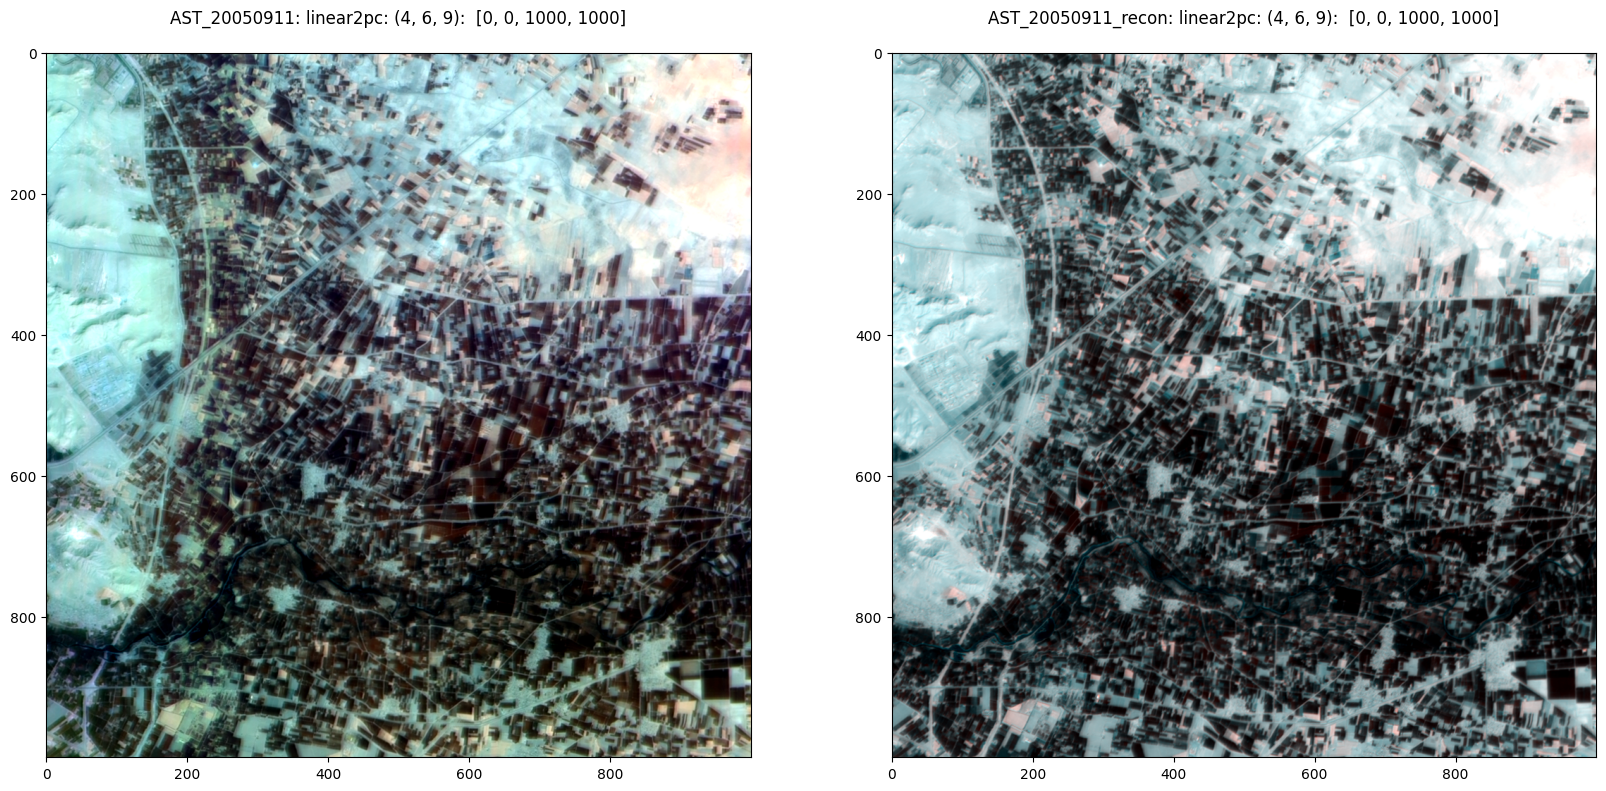

In [5]:
%run scripts/dispms \
-f imagery/AST_20050911 -p [4,6,9] -e 3 \
-F imagery/AST_20050911_recon -P [4,6,9] -E 3  \
-s '/home/mort/LaTeX/new projects/CRC5/Chapter3/fig3_11.eps'

### 3.3.4 Dual solution

In [12]:
# column-centered data matrix for random 2D data
m, N = 100, 2
G = np.mat(2*np.random.rand(m, N))-1
# covariance matrix
S = G.T*G/(m-1)
# Gram matrix
K = G*G.T
lambda_s, _ = np.linalg.eigh(S)
lambda_k, _ = np.linalg.eigh(K)
# sort eigenvalues in decreasing oder
idx = np.argsort(lambda_s)[::-1]
lambda_s = lambda_s[idx]
idx = np.argsort(lambda_k)[::-1]
lambda_k = lambda_k[idx]
# compare
print(lambda_s)
print(lambda_k[0:3]/(m-1))

[0.35884327 0.31977873]
[3.58843267e-01 3.19778726e-01 1.18459697e-16]


## 3.5 Spatial correlation

### 3.5.2 Noise estimation

In [13]:
run scripts/ex3_2 imagery/AST_20070501.tif

Noise covariance, file imagery/AST_20070501.tif
[[15.89 15.5  -0.21  1.45  0.45  0.51  0.44  0.36  0.24]
 [15.5  16.93 -2.69  1.58  0.5   0.57  0.49  0.4   0.26]
 [-0.21 -2.69 24.95 -0.17 -0.1  -0.11 -0.1  -0.08 -0.06]
 [ 1.45  1.58 -0.17  0.21  0.06  0.07  0.06  0.05  0.03]
 [ 0.45  0.5  -0.1   0.06  0.02  0.02  0.02  0.02  0.01]
 [ 0.51  0.57 -0.11  0.07  0.02  0.03  0.02  0.02  0.01]
 [ 0.44  0.49 -0.1   0.06  0.02  0.02  0.02  0.02  0.01]
 [ 0.36  0.4  -0.08  0.05  0.02  0.02  0.02  0.01  0.01]
 [ 0.24  0.26 -0.06  0.03  0.01  0.01  0.01  0.01  0.01]]


------------MNF ---------------
Tue Jul 30 16:38:19 2024
Input imagery/AST_20070501.tif
Signal to noise ratios: [686.32 143.42 104.36 100.95  61.8   35.9   15.71  14.7    7.15]


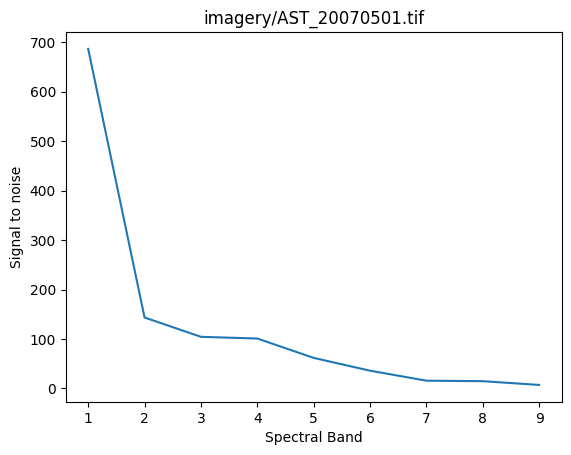

MNFs written to: imagery/AST_20070501_mnf.tif
elapsed time: 0.629584789276123


In [14]:
run scripts/mnf imagery/AST_20070501.tif

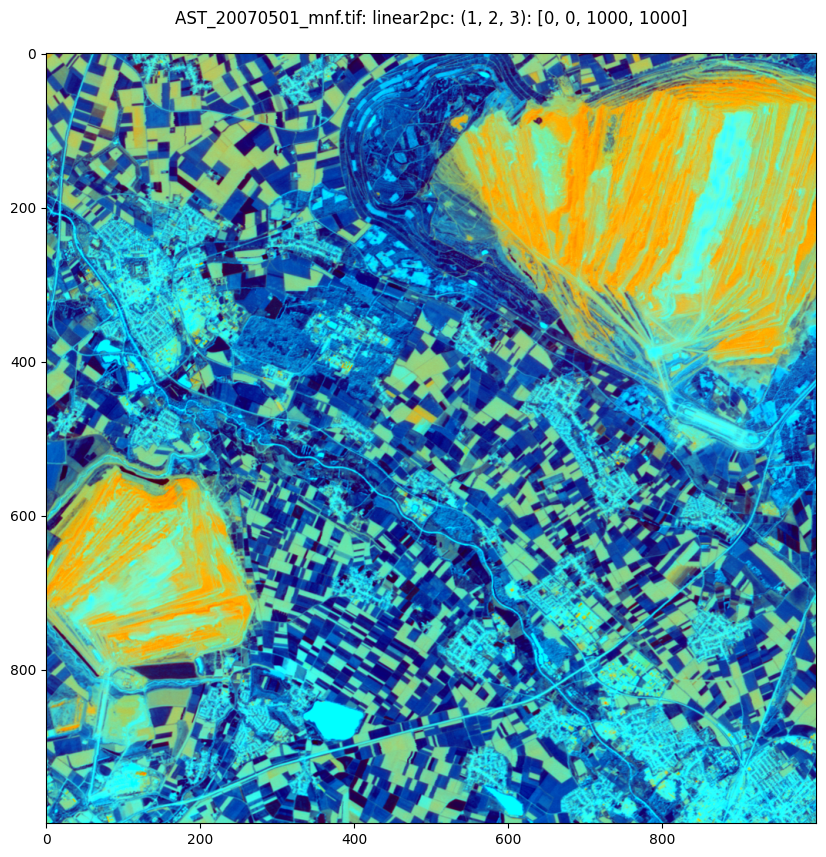

In [15]:
%run scripts/dispms -f imagery/AST_20070501_mnf.tif -p [1,2,3] -e 3 \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter3/fig3_12.eps' 

## 3.6 Exercises

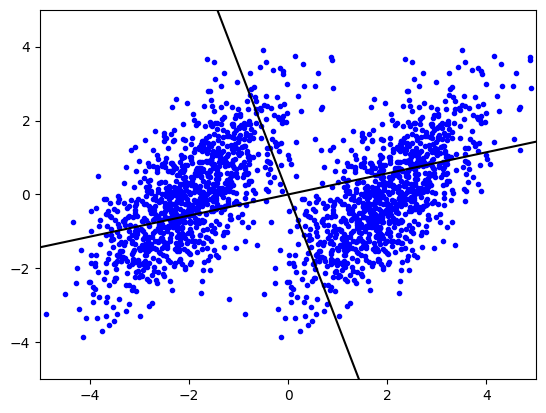

In [16]:
# a 2D two-class image
n1 = np.random.randn(1000)
n2 = n1 + np.random.randn(1000)
B1 = np.zeros((1000,2))
B2 = np.zeros((1000,2))
B1[:,0] = n1
B1[:,1] = n2
B2[:,0] = n1+4
B2[:,1] = n2
G = np.concatenate((B1,B2))
# center the image
G[:,0] = G[:,0] - np.mean(G[:,0])
# estimate covariance and diagonalize
C = np.mat(G).T*np.mat(G)/2000
_,U = np.linalg.eigh(C)
# slopes of the principal axes
s1 = U[1,1]/U[0,1]
s2 = U[1,0]/U[0,0]
# plot
plt.xlim((-5,5))
plt.ylim((-5,5))
plt.plot(G[:,0],G[:,1],'b.',
         [-5,5],[-5*s1,5*s1],'k',
         [-5,5],[-5*s2,5*s2],'k')

#plt.savefig('/home/mort/LaTeX/new projects/CRC5/Chapter3/fig3_13.eps',bbox_inches='tight')